                                       Initial Setup: Always run before anything else 

In [1]:
import numpy as np
import os, sys, math, csv, xlwt, operator
from astropy.io import fits
from astropy.stats import LombScargle
from photutils import aperture_photometry as photometry
from photutils import CircularAperture as circle
from photutils import CircularAnnulus as annulus
from photutils import RectangularAperture as rectangle
from photutils import ApertureMask as mask
import matplotlib.pyplot as plt
import matplotlib as mpl
import statistics
from xlwt import Workbook 
%matplotlib inline
np.set_printoptions(threshold=np.nan)


In [2]:
#define things about the main star
star_location_y = 2121
star_location_x = 4005
r_main= 3 #radius of main star aperture 

#define thins about comparison stars
comp_star_location_brightness = "fnaql_comparison_stars.txt" #name of file to be created with possible reference stars
reference_img_for_comp_stars = "13_eastS.dat" #reference image
num_stars_to_extract = 20 #stars to extract data for 
r_comparison = 3 #racius of comparison star aperture

table_directory = 'reference_txt_files/'
star_folder = table_directory+'star_tables/' #directory of folder in which star tables will be written

table_median_MAD_file_name="table_median_MAD.txt"

num_stars_kept = 8 #final amount of comparison stars desired
number_of_clippings = 4 #how many times should the clipping method be run
clipping_treshold = 2.5 # what flux values should be rejected from the analysis, in multiples of MAD


#define things about the cutouts
cutout_directory = 'fnAql_cuts/' # location for image cutouts. currently running on only 100ish images
size=200



                                      Creating Image Cutouts ~RUN ONLY ONCE~

In [ ]:
#define things about large images
initial_directory = 'Full_Images/' # path of directory that contains full image fits files

#define things about the main star
cutout_x_start = int(round(star_location_x-size/2))
cutout_x_stop = cutout_x_start+size
cutout_y_start = int(round(star_location_y-size/2))
cutout_y_stop = cutout_y_start+size


all_files=os.listdir(initial_directory) #extract list of files
file_count = len(all_files) # gives number of files in directory
sort_files = sorted(all_files) # sort directory in alphanumeric order
full_img_list = [os.path.join(initial_directory, sort_files[i]) for i in range(0,file_count)] # create file path names for full image files

# a loop to create image cutouts
for i in range(0,file_count):
  #extract data
    full_Image_Data = fits.getdata(full_img_list[i]) #take out data from file (pixel values are in 'section' 1)
    full_Image_Header= fits.getheader(full_img_list[i], ext=1)
  #collect necessary data
    this_data= full_Image_Data[cutout_y_start:cutout_y_stop, cutout_x_start:cutout_x_stop]  #choose area of data to keep
    cutoutName='cutout_'+all_files[i][len(all_files[i])-20:] #appends 'cutout' to the date and id of photo
    destination=cutout_directory+cutoutName  #define destination of new file
  #save the image
    fits.writeto(destination, this_data, full_Image_Header)  #save fits file    
print('done')

                                     Listing Comparison Stars ~RUN ONLY ONCE~

In [ ]:
#RUN ONLY ONCE
# to create a file of stars that are potential candidates for comparison stars to the target
b=open(os.path.join(table_directory,comp_star_location_brightness),"w+")
b.write("x_coord y_coord brightness distance")

#extract candidate data from .dat file
x_coord, y_coord, brightness, = np.loadtxt(reference_img_for_comp_stars,unpack=True,usecols=(0,1,3))

#create list of stars
with open(reference_img_for_comp_stars, "r") as f:
    Bright_List=[]
    lines = f.readlines()
    i=1
    #collect all stars that are within range
    while i < len(x_coord):
        if i != 0:           
            x_coord_now, y_coord_now, brightness_now=x_coord[i], y_coord[i], brightness[i]    
            Diff_X = abs(float(star_location_x) - float(x_coord_now))
            Diff_Y = abs(float(star_location_y) - float(y_coord_now))  
            
            if (Diff_X+r_comparison) <= size/2  and (Diff_Y+r_comparison) <= size/2: 
                distance = math.sqrt(((abs(Diff_X))**2)+abs((Diff_Y)**2))
                Bright_List.append([x_coord_now,y_coord_now,brightness_now,round(distance,3)])
        i += 1
    #sort by brightness and keep only the brightest stars
    Bright_List.sort(key = lambda x: x[2]) 
    Bright_List_trimmed = Bright_List[0:num_stars_to_extract]  
    
    #write the stars to a file
    b.write('\n')
    for j in Bright_List_trimmed: 
        for k in j:
            b.write(str(k))
            b.write(' ')
        b.write('\n')  
b.close()
print('candidate list created')

                            Collecting flux data and making flux tables ~RUN ONLY ONCE~

In [70]:
# create file path names for cutout image files
cut_files=os.listdir(cutout_directory) #extract list of files
file_count = len(cut_files) # gives number of files in directory
cutout_img_list = [os.path.join(cutout_directory, sorted(os.listdir(cutout_directory))[i]) for i in range(0,file_count)]

cutout_data =[]
for i in range (0,file_count):
    image=fits.open(cutout_img_list[i]) #open file
    imageData = image[0].data  #take out data from file (data is in 'section' 1)
    image.close()
    cutout_data.append(imageData)

In [71]:
# define comparison star coordinates and radii from an existing text file 

x_coord, y_coord = np.loadtxt(os.path.join(table_directory, comp_star_location_brightness),skiprows=1,
                              unpack=True,usecols=(0,1))
comp_star_info_file= open(os.path.join(table_directory, "comp_star_info.txt"),"w+")
comp_star_info_file.write("ID x_coord y_coord radius \n")

#take star list and change x y coord
# process of changing location to pixels within the cutout
for i in range(len(x_coord)):
    # calculate location in terms of local pixels
    location_in_cutout_x= int(round(size/2+(x_coord[i]-star_location_x)))
    location_in_cutout_y= int(round(size/2+(y_coord[i]-star_location_y)))
    
    # create list of circles to plot, removing those whose aperture doesn't fit in cutout
    if location_in_cutout_x >= r_comparison and location_in_cutout_y >= r_comparison and \
    location_in_cutout_x <= size-r_comparison and location_in_cutout_y <= size-r_comparison:
        comp_star_info_file.write(str(i)+' '+str(location_in_cutout_x)+
                                  ' '+str(location_in_cutout_y)+' '+str(r_comparison)+ '\n')   
        
comp_star_info_file.close()


In [72]:
#create aperture circles for comp stars

comp_star_info_file= open(os.path.join(table_directory, "comp_star_info.txt"),"r")
comparison_stars= np.loadtxt(comp_star_info_file, skiprows=1)
comparison_star_circles= [] # empty list for background star circles
for i in range(len(comparison_stars)):
    newStar = comparison_stars[i] #ientify row for clearer use in the next line
    cutout_location_x = int(newStar[1])
    cutout_location_y = int(newStar[2])
    r_comparison = newStar[3]
    # create list of circles to plot, removing those whose aperture doesn't fit in cutout
    if cutout_location_x >= r_comparison and cutout_location_y >= r_comparison and \
    cutout_location_x <= size-r_comparison and cutout_location_y <= size-r_comparison:
        comparison_star_circles.append([i, circle((cutout_location_x,cutout_location_y-1),r_comparison)]) 
comp_star_info_file.close()



In [112]:
#write star fluxes into txt files, including main star
#create star flux tables, a list of all tables, a list of comparison star tables 
star_tables=[]

Mstar_file_name= os.path.join(star_folder, "main_star.txt")
Mstar_file= open(Mstar_file_name,"w+")
Mstar_file.write("time flux clip")
star_tables.append(Mstar_file_name)

for j in range(0, len(comparison_star_circles)):  
    star_file_name= os.path.join(star_folder,"comparison_star_"+str(j)+".txt")
    star_file= open(star_file_name,"w+")
    star_file.write("time flux clip")
    star_tables.append(star_file_name)
    
comp_star_tables= star_tables[1:]

#insert time and flux data into tables
#loop over all images
for i in range(0, file_count):
    # 5. extract time from cutout file
    image=fits.open(cutout_img_list[i]) #open file
    time_of_flux = image[0].header['JDT']  #take out data from file (data is in 'section' 1)
    image.close()
    for j in range(0, len(star_tables)):  
        # 3. calculate location in terms of local pixels
        if j==0:
            location_in_cutout_x= int(round(size/2))
            location_in_cutout_y= int(round(size/2))
            fluxSpace=circle((location_in_cutout_x,location_in_cutout_y), 3)
        else:
            location_in_cutout_x= comparison_stars[j-1][1]
            location_in_cutout_y= comparison_stars[j-1][2]
            fluxSpace=comparison_star_circles[j-1][1]
            
        # 4. calculate flux with 'photometry' function for each cutout
        flux_of_star=photometry(cutout_data[i], fluxSpace, method = 'exact') 
        
        # 5. write as flux and time table text file
        with open(star_tables[j], 'a') as file:
            file.write("\n" + str(time_of_flux) +" "+ str(flux_of_star[0][3])+" 1")

                               Sigma clipping of comparison stars ~RUN ONLY ONCE~

In [113]:
clipMainStarInput=input('do you want to clip the main Star? y/n  ')
clipMainStar=False

if clipMainStarInput =='y':
    clipMainStar=True

do you want to clip the main Star? y/n  y


In [114]:
#if cells above were run, comp_star_tebles and comparison_star_circles exist,
#else this creates the lists
try:
    comp_star_tables
except NameError:
    print('making list')
    comp_star_tables=os.listdir(star_folder)
    comp_star_tables= [os.path.join(star_folder, comp_star_tables[i]) for i in range(len(comp_star_tables))]
    os.listdir(star_folder) #extract list of files
    comp_star_tables.sort(key=len)
    comp_star_tables.pop(0) #remove the first file, which is the main star
else:
    print('comp_star_tables exists')
    
try:
    comparison_star_circles
except NameError:
    comp_star_info_file= open(os.path.join(table_directory, "comp_star_info.txt"),"r")
    #create aperture circles for comp stars
    comparison_stars= np.loadtxt(comp_star_info_file, skiprows=1)
    comparison_star_circles= [] # empty list for background star circles
    for i in range(len(comparison_stars)):
        newStar = comparison_stars[i] #ientify row for clearer use in the next line
        cutout_location_x = int(newStar[1])
        cutout_location_y = int(newStar[2])
        r_comparison = newStar[3]
        # create list of circles to plot, removing those whose aperture doesn't fit in cutout
        if cutout_location_x >= r_comparison and cutout_location_y >= r_comparison and \
        cutout_location_x <= size-r_comparison and cutout_location_y <= size-r_comparison:
            comparison_star_circles.append([i,circle((cutout_location_x,cutout_location_y-1),r_comparison)]) 
    comp_star_info_file.close()
else:
    print ('comparison_star_circles exists')

comp_star_tables exists
comparison_star_circles exists


In [115]:
#define functions of finding median and sigma of fluxes
def Median(Array):
    temporary_fluxes=[]
    for i in range(0, len(Array)):
        if Array[i][2] == 1:
            temporary_fluxes.append(Array[i][1])
    med= statistics.median(temporary_fluxes)
    return med

def MAD(median, Array):
    temporary_fluxes = []
    for i in range (len(Array)):
        if Array[i][2] == 1:   
            temporary_fluxes.append(abs(median-Array[i][1]))
    mad=statistics.median(temporary_fluxes) 
    return mad

In [116]:
#sigma clipping of the main star
#only if want to
if clipMainStar:
    #input:
    main_num_of_clippings= 4
    main_threshold= 2.5

    #main star fluxes 
    main_star_data= np.loadtxt(os.path.join(star_folder,"main_star.txt"), skiprows=1)
        # time  flux  clip value

    #clipping process
    for clip in range(main_num_of_clippings):
        median=Median(main_star_data)
        mad= MAD(median,main_star_data)
        for i in range(len(main_star_data)):
            flux=main_star_data[i][1]
            if abs(flux-median)>(main_threshold*mad):
                main_star_data[i][2]=0

    #output: 
    #clipped main star fluxes
    # - put into file

    main_file= open(os.path.join(star_folder,"main_star.txt"),"w+")
    main_file.write("time flux clip")
    for j in range(len(main_star_data)):
        main_file.write("\n" + str(main_star_data[j][0]) +" "+ str(main_star_data[j][1])+" "+ str(main_star_data[j][2]))
    main_file.close()

In [117]:
#clipping of the comparison stars
comp_num_of_clippings = 4
comp_threshold = 2.5

table_median_MAD=[]
table_median_MAD_file=open(os.path.join(table_directory, table_median_MAD_file_name),"w+")
table_median_MAD_file.write("ID tableName medianValue MAD")

for star in range(len(comp_star_tables)):
    comp_star_data = np.loadtxt(comp_star_tables[star], skiprows=1)
    # time  flux  clip value

    #clipping process
    for clip in range(comp_num_of_clippings):
        median=Median(comp_star_data)
        mad= MAD(median,comp_star_data)
        for i in range(len(comp_star_data)):
            flux=comp_star_data[i][1]
            if abs(flux-median)>(comp_threshold*mad):
                comp_star_data[i][2]=0

    #output: 
    #MAD table
    table_median_MAD.append([star, comp_star_tables[star],median,mad])
    table_median_MAD_file.write('\n'+str(star)+' '+str(comp_star_tables[star])+' '+str(median)+' '+str(mad))
    #clipped comp star fluxes
    # - put into file
    comp_file= open(os.path.join(star_folder,"comparison_star_"+str(star)+".txt"),"w+")
    comp_file.write("time flux clip")
    for j in range(len(comp_star_data)):
        comp_file.write("\n" + str(comp_star_data[j][0]) +" "+ str(comp_star_data[j][1])+" "+ str(int(comp_star_data[j][2])))
    comp_file.close()
    
table_median_MAD_file.close()

In [118]:
#define functions for sorting the stars and collect circular apertres for wanted ones
def sort_table(table, col):
    return sorted(table, key=operator.itemgetter(col))

def removeCompStars(array, amountKept, table):
    chosen_comparison_star_circles=[]
    for num in range (0, amountKept):
        circle_to_add=table[num][0]
        chosen_comparison_star_circles.append(array[circle_to_add])
    return chosen_comparison_star_circles
#sort the star table and create array of wanted stars then save chosen strs into file
table_median_MAD= sort_table(table_median_MAD,3)
chosen_comparison_star_circles=removeCompStars(comparison_star_circles, num_stars_kept, table_median_MAD)

IDs=[]
for line in range(num_stars_kept):
    IDs.append(table_median_MAD[line][0])

comp_star_info_file= open(os.path.join(table_directory, "comp_star_info.txt"),"r")
comparison_stars = np.loadtxt(comp_star_info_file, skiprows=1)

chosen_comparison_stars_file=open(os.path.join(table_directory, "chosen_comp_stars.txt"),"w+")
chosen_comparison_stars_file.write("ID xValue yValue radius")

for line in range(len(IDs)):
    ID=IDs[line]
    for i in range(len(comparison_stars)):
        if ID == comparison_stars[i][0]:
            chosen_comparison_stars_file.write('\n'+str(int(comparison_stars[i][0]))+' '+str(int(comparison_stars[i][1]))+' '
                                              +str(int(comparison_stars[i][2]))+' '+str(int(comparison_stars[i][3])))

chosen_comparison_stars_file.close()

                              ~  Light Curve and Phase Curve Production ~

                                     Producing Reference Images

In [119]:
# variables for the graphs

display_file = 0 # target file number to display target image. It can stay hardcoded, it's only for our reference

x_aperture = 11 # x coordinate of target aperture center within the star cutout 
y_aperture = 10 # y coordinate of target aperture center within the star cutout 
r = 2 # radius of target aperture

x_background = x_aperture # x coordinate of background annulus center
y_background = y_aperture # y coordinate of background annulus center
r_in = 8 # inner radius of background annulus (in pixels)
r_out = r_in + 1 # outer radius of background annulus

#a size large enough for the background annulus with 2px of padding on each side
target_img_size= (r_out+2)*2 # x by x pixel size of target image

low_period = 1.5 # lowest period for LombScargle to test on target star (days)
high_period = 20# highest period for LombScargle to test on target star (days)

In [120]:
try:
    cutout_data
except NameError:
    cut_files=os.listdir(cutout_directory) #extract list of files
    file_count = len(cut_files) # gives number of files in directory
    sort_files = sorted(cut_files) # sort directory in alphanumeric order
    cutout_img_list = [os.path.join(cutout_directory, sorted(os.listdir(cutout_directory))[i]) for i in range(0,file_count)]

    cutout_data =[]
    for i in range (0,file_count):
        image=fits.open(cutout_img_list[i]) #open file
        imageData = image[0].data  #take out data from file (data is in 'section' 1)
        image.close()
        cutout_data.append(imageData)
        
try:
    chosen_comparison_star_circles
except NameError:
    chosen_comparison_stars=np.loadtxt(os.path.join(table_directory, "chosen_comp_stars.txt"),skiprows=1)
    chosen_comparison_star_circles=[]
    for i in range(len(chosen_comparison_stars)):
        x = int(chosen_comparison_stars[i][1])
        y = int(chosen_comparison_stars[i][2])
        r = int(chosen_comparison_stars[i][3])
        chosen_comparison_star_circles.append([i, circle((x,y), r)])    

#adjust to only take chosen stars

try:
    comp_star_tables
except NameError:
    print('making list')
    chosen_comparison_stars=np.loadtxt(os.path.join(table_directory, "chosen_comp_stars.txt"),skiprows=1)
    all_comp_star_tables=os.listdir(star_folder)
    all_comp_star_tables= [os.path.join(star_folder, all_comp_star_tables[i]) for i in range(len(all_comp_star_tables))]
    os.listdir(star_folder) #extract list of files
    all_comp_star_tables.sort(key=len)
    all_comp_star_tables.pop(0) #remove the first file, which is the main star
    comp_star_tables=[]
    for i in range(len(all_comp_star_tables)):
        for j in range (num_stars_kept):
            if int(chosen_comparison_stars[j][0]) == i:
                comp_star_tables.append(all_comp_star_tables[i])


In [121]:
#define placement of main star apreture on images

center = size/2 # calculate center location of target image
target = cutout_data[display_file][int(center-target_img_size/2):int(center+target_img_size/2),int(center-target_img_size/2):int(center+target_img_size/2)] # create array of target image data values for specified file
aperture_main_cutout = circle((x_aperture,y_aperture), r) # create circular aperture around target
background_main_cutout = annulus((x_background,y_background), r_in, r_out) # create annulus for background flux

#place aperture and annulus of main star on large image
offset = (len(cutout_data[display_file])-target_img_size)/2 # calculate difference between center coordinates of target image and comparison stars image
aperture_large_cutout = circle((x_aperture+offset,y_aperture+offset), r) # place aperture on target star in comparison stars image
background_large_cutout = annulus((x_background+offset,y_background+offset), r_in, r_out) # place background annulus so that it is surrounding target star in comparison stars image

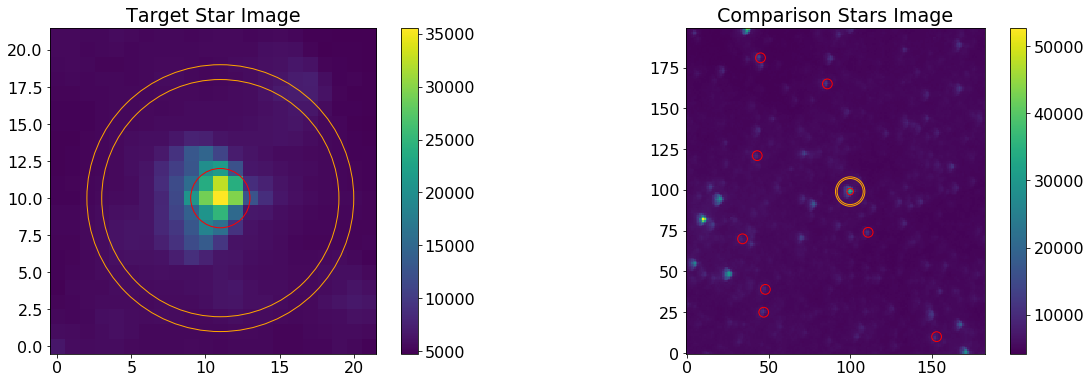

In [122]:
###check table median MAD

# create target image with target aperture and background annulus
mpl.rcParams['figure.figsize'] = (20,6)
mpl.rcParams['font.size'] = 16

def target_star_image():
    plt.subplot(121)
    plt.title('Target Star Image')
    plt.imshow(target, origin='lower')
    plt.colorbar()
    aperture_main_cutout.plot(color='red')
    background_main_cutout.plot(color='orange')

# create comparison stars image with target aperture, comparison apertures, and background annulus
def comparison_star_image():
    plt.subplot(122)
    plt.title('Comparison Stars Image')
    plt.imshow(cutout_data[display_file], origin='lower')
    plt.colorbar()
    aperture_large_cutout.plot(color='red')
    background_large_cutout.plot(color='orange')
    for i in range(len(chosen_comparison_star_circles)):
        chosen_comparison_star_circles[i][1].plot(color='red')

target_star_image()
comparison_star_image()
plt.show()


                                             Star Flux vs. Time

In [123]:
#collect time values from one of the star tables for graphing 
time=[]
table=np.loadtxt(comp_star_tables[0], skiprows=1)
for line in range(0,len(table)):
    time.append(table[line][0])

graphing_time=[time[i]-2450000 for i in range(len(time))] #alter timestamps to avoid the bulky 245 beginning

In [124]:
print(len(time))
print(len(graphing_time))
print(len(table))

888
888
888


In [125]:
#allow user to choose time frame for analysis, if desired

beginning_timestamp=0
end_timestamp=len(time)-1

if input("custom time frame? y/n: ")== 'y':
    beginning_input=int(input ("input beginning JDT date "))
    end_input=int(input ("input ending JDT date "))
    for i in range (0, len(time)):
        if beginning_input <= time[i]:
            beginning_timestamp= i
            break
    for i in range (beginning_timestamp, len(time)):
        if end_input <= time[i]:
            end_timestamp= i
            break

print(beginning_timestamp)
print(end_timestamp)

graphing_time= graphing_time[beginning_timestamp:end_timestamp]

custom time frame? y/n: 
0
887


In [126]:
def normalizing(Array):
    maxValue=max(Array)
    minValue=min(Array)
    return [(Array[i])/(maxValue) for i in range(0,len(Array))]

In [127]:
main_star_flux=[]
main_indeces=[]
with open(os.path.join(star_folder, "main_star.txt"),'r') as f:
    next(f)
    i=0
    for line in f:
        if float(line.split()[2])==1:
            main_star_flux.append(float(line.split()[1]))
            main_indeces.append(i)
        else:
            main_star_flux.append(0)
        i+=1
    f.close()
    
normalized_main_star_flux=normalizing(main_star_flux)

In [128]:
print(len(time))

888


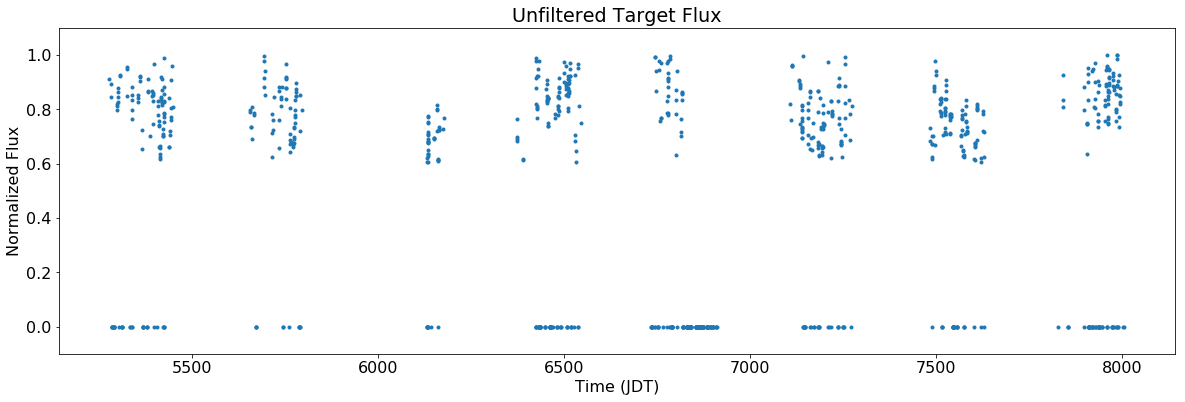

In [129]:
#create flux v. time plot
plt.xlabel('Time (JDT)')
plt.ylabel('Normalized Flux')
      
#rounding x tick marks
roundDecimals=2
difference=(max(time)+1-min(time))

while difference>=10:
    difference= difference/10
    roundDecimals=roundDecimals-1
if difference<=1:   
    roundDecimals=roundDecimals-2
    while difference<=1:
        difference= difference/10
        roundDecimals=roundDecimals+1

#plotting    
normalized_main_star_flux= normalized_main_star_flux[beginning_timestamp:end_timestamp]

def target_star_flux_graph():
    plt.title('Unfiltered Target Flux') 
    plt.plot(graphing_time, normalized_main_star_flux, '.')

target_star_flux_graph()
axes=plt.gca()
axes.set_ylim([-.1,1.1])
plt.show()

                                   Comparison Star Flux vs. Time

In [130]:
# collect fluxes and create avg reference flux for each timestamp

# process:
# make a list of comp star fluxes
# use flux*clip value for the flux values to make sure we disregard unwanted values
# use total fluxes for each line to count how many non-0 values are in the line

comp_star_flux_table = [] #create table for fluxes

#initialize the table with 0s. format: [total flux in timestamp, number of non-zero fluxes in timestamp]
for i in range(len(time)):
    comp_star_flux_table.append([0,0])

#sum up fluxes from all stars and count non-zero fluxes, place in the table
for i in range(len(comp_star_tables)):
    with open(os.path.join(comp_star_tables[i]),'r') as f:
        next(f)#skip header line
        lineNum=0
        for line in f:
            flux = float(line.split()[1])*float(line.split()[2])
            if flux!=0:
                comp_star_flux_table[lineNum][0]+=flux
                comp_star_flux_table[lineNum][1]+=1
            lineNum+=1
        f.close()


# then make a table of avg comp star flux values
comp_star_flux=[]
for i in range(len(comp_star_flux_table)):
    if comp_star_flux_table[i][1]==0:
        comp_star_flux.append(0)
    else:
        comp_star_flux.append(comp_star_flux_table[i][0]/comp_star_flux_table[i][1])

normalized_comp_star_flux=normalizing(comp_star_flux)

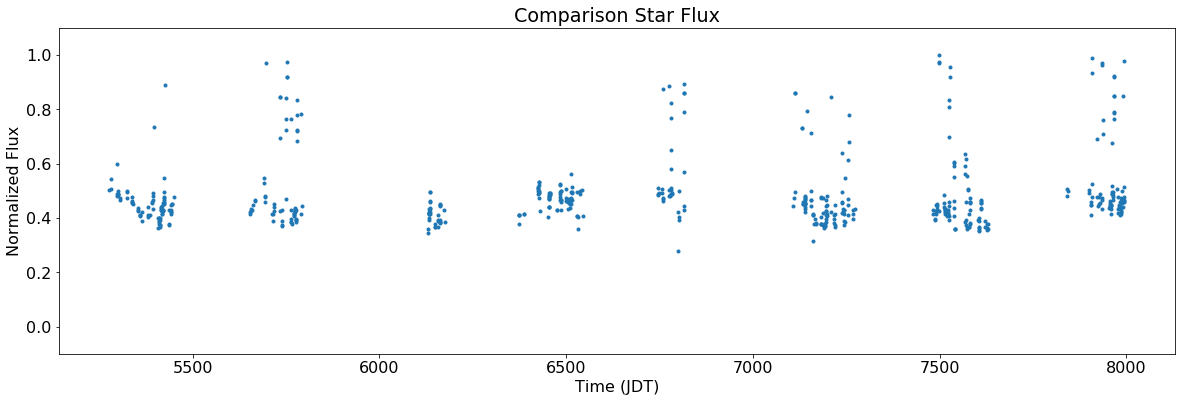

In [131]:
# create comparison flux vs. time plot
plt.xlabel('Time (JDT)')
plt.ylabel('Normalized Flux')

normalized_comp_star_flux= normalized_comp_star_flux[beginning_timestamp:end_timestamp]

non_zero_comp_fluxes=[]
non_zero_times=[]
non_zero_main=[]
for i in range(len(normalized_comp_star_flux)):
    if normalized_comp_star_flux[i]!=0 and main_star_flux[i]!=0:
        non_zero_comp_fluxes.append(comp_star_flux[i])
        non_zero_times.append(graphing_time[i])
        non_zero_main.append(main_star_flux[i])
        
normalized_non_zero_comp_fluxes=normalizing(non_zero_comp_fluxes)

def comparison_stars_flux_graph():
    plt.title('Comparison Star Flux')
    plt.plot(non_zero_times, normalized_non_zero_comp_fluxes, '.')
        
comparison_stars_flux_graph()
axes=plt.gca()
axes.set_ylim([-.1,1.1])
plt.show()

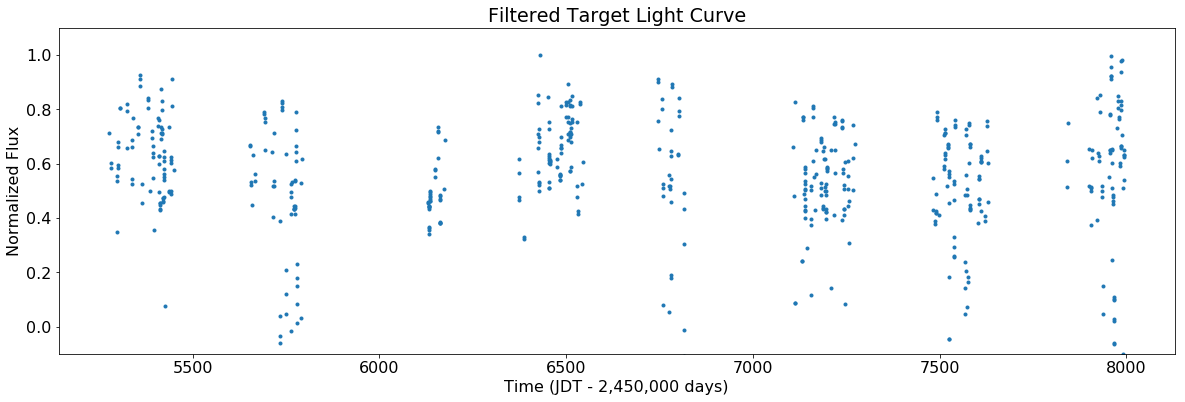

In [132]:
# create target light curve with target flux minus comparison flux vs. time 
plt.title('Filtered Target Light Curve')
plt.xlabel('Time (JDT - 2,450,000 days)')
plt.ylabel('Normalized Flux')

final_flux = np.subtract(non_zero_main, non_zero_comp_fluxes) 
final_flux= final_flux[beginning_timestamp:end_timestamp]
normalized_final_flux=normalizing(final_flux)

plt.plot(non_zero_times, normalized_final_flux, '.') 
axes=plt.gca()
axes.set_ylim([-.1,1.1])
plt.show()

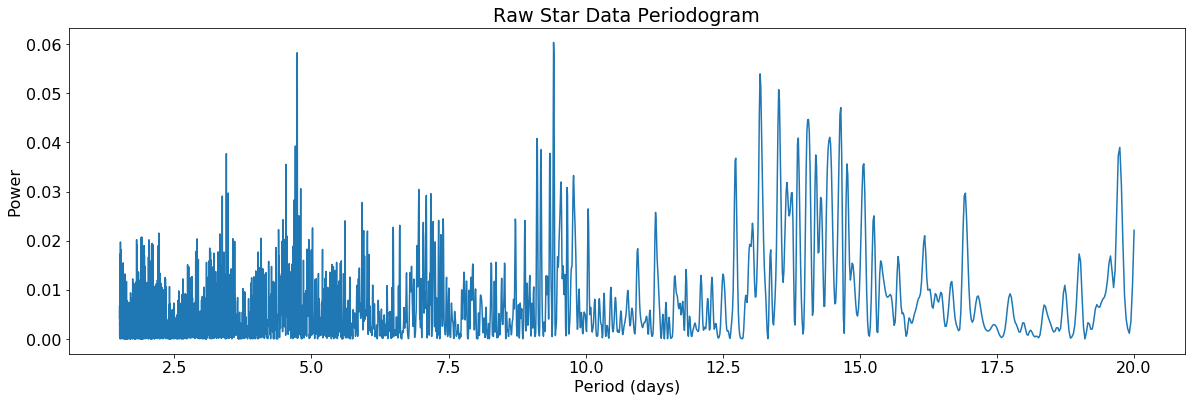

best period for range 1.5 to 20 days = 9.414491410997861 days
power value for best period =  0.06031867349972217


In [133]:
# periodogram with raw main star data

raw_frequency, raw_power = LombScargle(time, main_star_flux).autopower(minimum_frequency = 1/high_period, maximum_frequency = 1/low_period)
    
raw_best_frequency = raw_frequency[np.argmax(raw_power)] # find frequency with highest power value
raw_period = 1/raw_best_frequency # convert this frequency to a period
raw_low = np.argmin(main_star_flux) # find lowest value of flux 

raw_phase_offset = 0.5 - np.remainder(time[raw_low], raw_period) / raw_period # calculate phase offset so that lowest flux value in each cycle is located at half the period
raw_phase = np.remainder(time + raw_phase_offset * raw_period, raw_period * 2) / raw_period # calculate the phase of the target flux for two cycles


# create target periodogram with power vs. period
plt.plot(1/raw_frequency, raw_power)
plt.title('Raw Star Data Periodogram')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.show()
# print the most likely period with its corresponding power value for the target star

print("best period for range", low_period, "to", high_period, "days =", raw_period, "days")
print("power value for best period = ", max(raw_power))

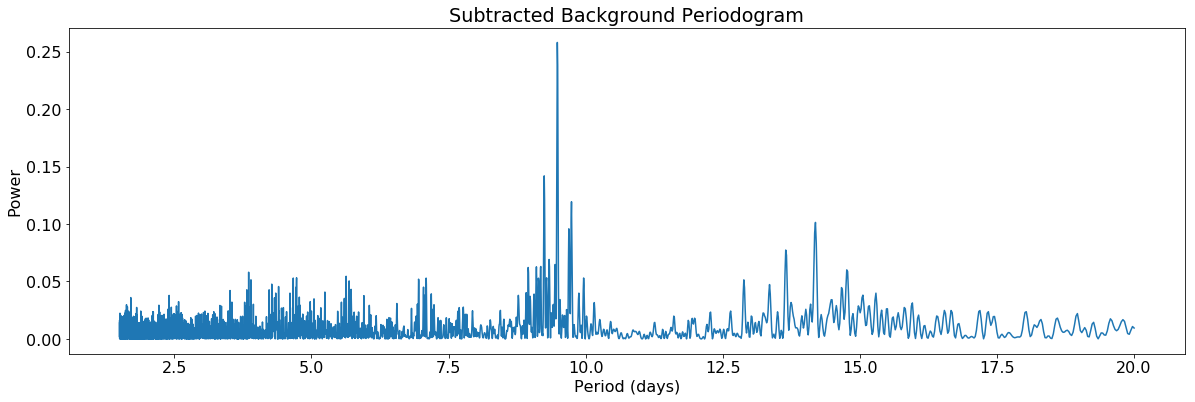

best period for range 1.5 to 20 days = 9.482595510975603 days
power value for best period =  0.2579378549166029


In [145]:
# periodogram with removed background

frequency, power = LombScargle(non_zero_times, final_flux).autopower(minimum_frequency = 1/high_period, maximum_frequency = 1/low_period)
    
best_frequency = frequency[np.argmax(power)] # find frequency with highest power value
period = 1/best_frequency # convert this frequency to a period
low = np.argmin(final_flux) # find lowest value of flux 

phase_offset = 0.5 - np.remainder(non_zero_times[low], period) / period # calculate phase offset so that lowest flux value in each cycle is located at half the period
phase = np.remainder(non_zero_times + phase_offset * period, period) / period # calculate the phase of the target flux for two cycles

# create target periodogram with power vs. period
plt.plot(1/frequency, power)
plt.title('Subtracted Background Periodogram')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.show()
# print the most likely period with its corresponding power value for the target star

print("best period for range", low_period, "to", high_period, "days =", period, "days")
print("power value for best period = ", max(power))

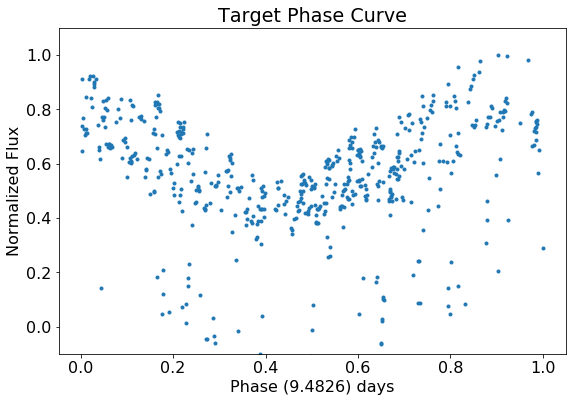

In [146]:
# create target phase curve with flux vs. phase
phase= phase[beginning_timestamp:end_timestamp]

plt.subplot(121)

plt.plot(phase, normalized_final_flux, '.')
plt.title('Target Phase Curve')
xLabel= 'Phase ('+ str(round(period,4))+ ') days'
plt.xlabel(xLabel)
plt.ylabel('Normalized Flux')
axes=plt.gca()
axes.set_ylim([-.1,1.1])
plt.show()

Amplitude=-19209.340078572666
Angular freq.=115.42583701232654
phase=-6.232884730308781
offset=147683.77767220934
Max. Cov.=14400376.149118312


TypeError: 'numpy.float64' object cannot be interpreted as an integer

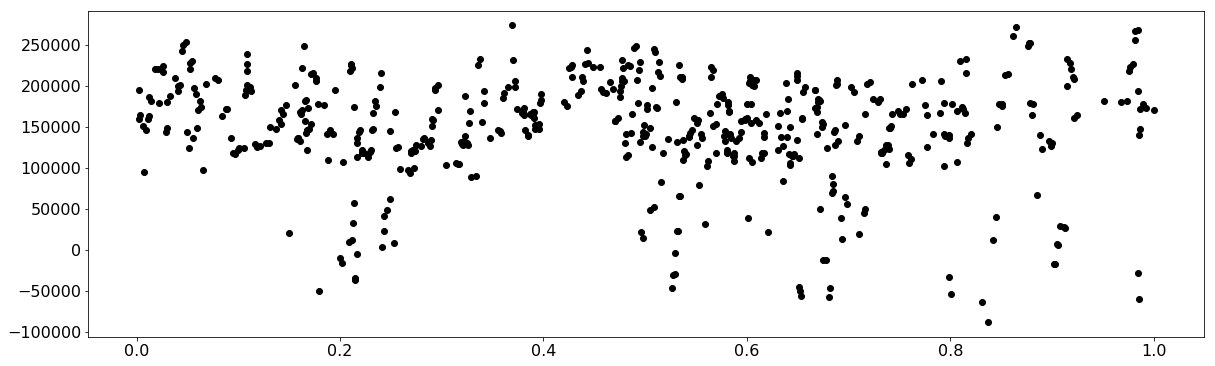

In [160]:
import scipy.optimize
import pylab as plt

#Fit sin to the input time sequence, and return fitimeing parameters
# "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"
def fit_sin(time, point):
    ff = np.fft.fftfreq(len(time), (time[1]-time[0]))   # assume uniform spacing
    Fpoint = abs(np.fft.fft(point))
    guess_freq = abs(ff[np.argmax(Fpoint[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(point) * 2.**0.5
    guess_offset = np.mean(point)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    popt, pcov = scipy.optimize.curve_fit(sinfunc, time, point, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}


def sinfunc(t, A, w, p, c):  
    return A * np.sin(w*t + p) + c

full_table=[]
for i in range(len(non_zero_times)):
    full_table.append([phase[i],final_flux[i]])

full_table=sorted(full_table, key=operator.itemgetter(0))

plotting_phase = [full_table[i][0] for i in range (len(full_table))]
plotting_flux = [full_table[i][1] for i in range (len(full_table))]

## fit data tables
# N= number of points to fit
# amp= the amplitude 
# omega= angular frequency
# phase= 
# offset= on the y axis
# noise= for making points
#N, amp, omega, phase2, offset, noise = 100, 1, 2, .5, 0, 1
res = fit_sin(plotting_phase, plotting_flux)
print("Amplitude=%(amp)s" % res)
print("Angular freq.=%(omega)s" % res)
print("phase=%(phase)s" % res)
print("offset=%(offset)s" % res)
print("Max. Cov.=%(maxcov)s" % res)

plt.plot(plotting_phase, final_flux, "ok", label="y with noise")
plt.plot(plotting_phase,
         res["fitfunc"](plotting_phase), "r-", label="y fit curve", linewidth=2)
plt.legend(loc="best")
plt.show()

In [159]:
print(full_table)


[[0.0025874383418492616, 249283.59610630883], [0.0026933666749481724, 177330.2756299207], [0.003056934693029081, 202603.7921656113], [0.005957617303063286, 209708.28667691798], [0.006928711915921581, 198735.4734299723], [0.009480333970284884, 193186.20900173346], [0.011261182491387401, 198823.4924314274], [0.012010238994745062, 195401.60684978898], [0.012490511431562998, 231762.8336408832], [0.014331755288666233, 194974.64350561087], [0.018503185378222743, 249223.1294889953], [0.02102285418247602, 252154.9369489114], [0.022558619775183277, 230104.12076055293], [0.02574609352926219, 221738.41067149426], [0.026109225292544204, 252291.31561378954], [0.028887722060508547, 244878.54280549206], [0.029638465878464134, 241264.27620535833], [0.029875852758563314, 245995.0489333694], [0.03243253675672039, 249322.67110100557], [0.038203625090076375, 203525.6670626486], [0.04052578337609264, 181070.40179605805], [0.040877478036265846, 177527.2633257013], [0.04305705236999277, 168915.85336571658], 

                                                Creating Flux Histogram

In [20]:
# cell for upcoming variables not previously defined

bin_size = 2500 # bin size for histogram

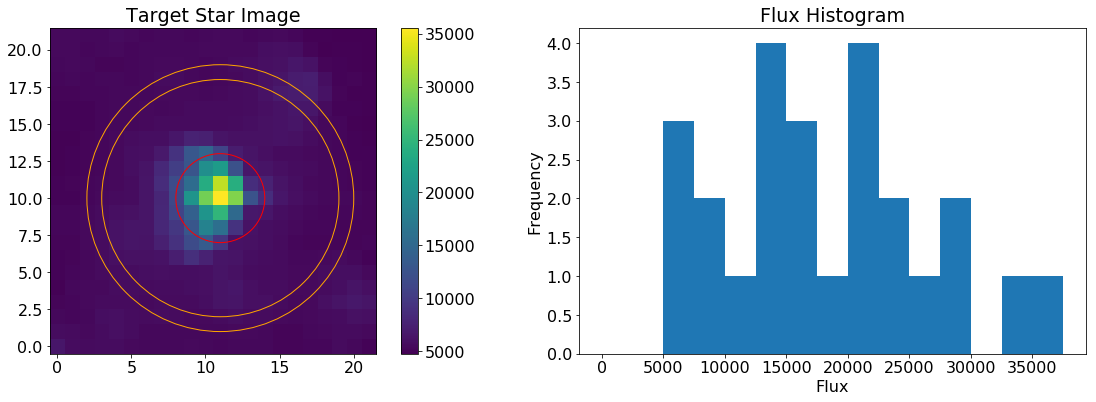

In [21]:
# create target image with target aperture and background annulus


aperture_mask = aperture_main_cutout.to_mask(method='center') # create mask over pixels in target aperture that have their centers within the annulus 
aperture_data = aperture_mask[0].multiply(target) # create array of flux values with zero values corresponding to data outside the mask and nonzero values corresponding to the data within the mask 
aperture_flux = aperture_data[aperture_mask[0].data > 0] # create array of flux values contained in mask

# create bins for histogram up to highest flux value in aperture
bins = np.arange(0,max(np.ndarray.flatten(target)+bin_size),bin_size) 

# create flux histrogram of values within target aperture
plt.subplot(122)
plt.hist(aperture_flux, bins);
plt.title('Flux Histogram')
plt.xlabel('Flux')
plt.ylabel('Frequency');
target_star_image()
plt.show()

                                            Examining Abnormal Flux Values

In [ ]:

# create target image with target aperture and background annulus
plt.subplot(121)
plt.title('Target Image')
plt.imshow(target, origin='lower')
plt.colorbar()
aperture_main_cutout.plot(color='red')
background_main_cutout.plot(color='orange')

mpl.rcParams['figure.figsize'] = (20,6)
mpl.rcParams['font.size'] = 16

target_data = [cutout_data[i][int(center-target_img_size/2):int(center+target_img_size/2),int(center-target_img_size/2):int(center+target_img_size/2)] for i in range(0,file_count)] # create array of target image data values for all files
target_sum = [photometry(target_data[i], aperture_main_cutout, method = 'exact') for i in range(0,file_count)] # sum up exact amount of flux contained in the target aperture
target_flux = np.array([target_sum[i]['aperture_sum'] for i in range (0,file_count)]) # get flux of target aperture without disregarding zero flux values


# create surrounding area image with target aperture and background annulus

plt.subplot(122)
plt.title('Target Image Surroudings')
plt.imshow(cutout_data[display_file], origin='lower')
plt.colorbar() 
aperture_large_cutout.plot(color='red') 
aperture_large_cutout.plot(color='orange')
plt.show()

#redefine time to contain timestamps even of 0 flux images
alltime=[]
for i in range(0,len(cutout_data)):
    cutout_file = fits.open(cutout_img_list[i])
    alltime.append(cutout_file[0].header['JDT'])
    cutout_file.close

# create light curve for target flux with zero flux values

plt.title('Target Flux')
plt.xlabel('Time (JDT)')
plt.ylabel('Flux')
plt.plot(alltime, target_flux, '.')
plt.show()

low_flux = 100000
high_flux = np.inf # upper limit for target flux values


# print flux values and corresponding file number for values that fall outside specified limits

print("Low Flux Values")
print("")
print("File    Target Flux")
for i in range(0,len(target_flux[target_flux < low_flux])):
    print(np.add(np.where(target_flux < low_flux),1)[0][i], "        ", target_flux[target_flux < low_flux][i])
print("")
print("")
print("")
print("High Flux Values")
print("")
print("File    Target Flux")
for i in range(0,len(target_flux[target_flux > high_flux])):
    print(np.add(np.where(target_flux > high_flux),1)[0][i], "        ", target_flux[target_flux > high_flux][i])